In [7]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


# Импорты

In [8]:
from google.colab import drive


import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split


# инструменты для оценки точности модели 
from sklearn import metrics 
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

# модуль для работы с полиноминальными признаками
from sklearn.preprocessing import PolynomialFeatures


# Модули для нахождения выбросов
from sklearn.cluster import DBSCAN

# Модули для маштабирования
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


# Модуль для вывода прогресса
from tqdm.notebook import tqdm

# Модули алгоритмов
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor  
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# модуль для подбора параметров модели
from sklearn.model_selection import GridSearchCV

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *

#import keras
from keras import optimizers
import albumentations

# Модули для визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Настройки Pandas

In [9]:
# Настройки Pandas
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 20)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', 20)

# Функции

In [10]:
def load(url,col_del):
    df = pd.read_csv(url).drop(col_del, axis = 1)
    return df


def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df


def PreProc(data, log_col,colum):
    # Отделяем таргет
    y = data.target
    
    # Удаляем таргет из данных
    data.drop(['target'], inplace = True,axis = 1)
    
    # Логарифмируем выбраные столбцы
    data[log_col] = np.log(data[log_col])
    
    # Закодируем категориальные признаки.
    for colum in cat:
        data[colum] = data[colum].astype('category').cat.codes

    # Нормализируем данные (RobustScaler должен быть устойчив к выбросам).
    scaler = RobustScaler() 
    for column in num_col:
        data[column] = scaler.fit_transform(data[[column]])[:,0]
    
    
    return y, data

# Загрузка данных

In [11]:
drive.mount('/content/gdrive', force_remount=True)
!ls /content/gdrive/
!ls /content/gdrive/"My Drive"
!cp /content/gdrive/'My Drive'/Diplom_project/data.csv .
!ls


Mounted at /content/gdrive
MyDrive
'Colab Notebooks'   SWOT.gsheet		       'Новая таблица.gsheet'
 Colab_Notebooks    TEMNIAKOVA_08_2021.gsheet   Остальное
 datasets	    TEMNIAKOVA_08_2021.xls     'Таблицы DataScience'
 Diplom_project    'Книги по IT'
data.csv  gdrive  sample_data


In [12]:
#url = '/content/gdrive/MyDrive/Diplom_project/df_after_FE_EDA.csv'
url = '/content/gdrive/MyDrive/Diplom_project/df_func_map.csv'

col_del = ['Unnamed: 0','fireplace','cooling','name','data_distance','data_grades',
           'rating','rating_sum','rating_mean','rating_median','data_distance_sum','data_distance_mean','data_distance_median']

In [13]:
# Загружаем данные
df = load(url,col_del)
df['mean_state_sqft'] = df['mean_state_sqft'] = df['state'].map(df.groupby('state')['sqft'].mean()) #!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [14]:
# При загрузке датасета проявляються столбцы с одинаковыми названиями применим функцию которая это исправит.
df = df_column_uniquify(df)

In [15]:
# Делим данные на трейн и вал.тест
Train, val, = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [16]:
data = Train
#data = df.copy()



# CatBoost

In [17]:
# Разделим признаки на числовые и категориальные
num_col = ['baths','sqft','beds','stories','PrivatePool','year_built',
           'remodeled_year','lotsize','price_sqft','mean_city_data_distance','year_built_mean_city',
           'year_remodeled_mean_city','mean_state_rating','mean_state_data_distance',
           'year_built_mean_state','year_remodeled_mean_state','beds__mean_state','median_city_sqft','mean_city_sqft','max_city_sqft','min_city_sqft',
           'min_state_sqft','mean_state_sqft','median_city_stories','mean_city_stories','min_state_stories',
           'mean_city_PrivatePool'
          ]


cat = ['status', 'propertyType', 'street','city', 'sqft', 
       'zipcode','state', 'heating','parking','propertyType_1','parking_',]


log_col = ['lotsize']

In [18]:
# Предобрабатываем данные трейна
y, data = PreProc(data, log_col,cat)

In [19]:
# Предобрабатываем данные вал теста
y_val, data_val = PreProc(val, log_col,cat)

In [20]:
# split данных
X_train, X_test, y_train, y_test = train_test_split(data, np.log(y), test_size=0.2, shuffle=True, random_state=42)

In [21]:
# Обучаем
model_cat = CatBoostRegressor(iterations = 40000,
                          learning_rate = 0.01,
                          l2_leaf_reg=2,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          task_type='GPU',

                         )
model_cat.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=1000,
         use_best_model=True,
         #plot=True
         )

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.0539140	test: 0.0540221	best: 0.0540221 (0)	total: 11.7ms	remaining: 7m 49s
1000:	learn: 0.0103783	test: 0.0104257	best: 0.0104257 (1000)	total: 5.79s	remaining: 3m 45s
2000:	learn: 0.0094355	test: 0.0095414	best: 0.0095414 (2000)	total: 11.4s	remaining: 3m 35s
3000:	learn: 0.0090382	test: 0.0092037	best: 0.0092037 (3000)	total: 16.9s	remaining: 3m 28s
4000:	learn: 0.0087876	test: 0.0090123	best: 0.0090123 (4000)	total: 22.5s	remaining: 3m 22s
5000:	learn: 0.0086030	test: 0.0088834	best: 0.0088834 (5000)	total: 28.1s	remaining: 3m 16s
6000:	learn: 0.0084579	test: 0.0087914	best: 0.0087914 (6000)	total: 33.7s	remaining: 3m 11s
7000:	learn: 0.0083407	test: 0.0087221	best: 0.0087221 (7000)	total: 39.3s	remaining: 3m 5s
8000:	learn: 0.0082379	test: 0.0086646	best: 0.0086646 (8000)	total: 44.9s	remaining: 2m 59s
9000:	learn: 0.0081452	test: 0.0086177	best: 0.0086177 (9000)	total: 52.3s	remaining: 3m
10000:	learn: 0.0080623	test: 0.0085770	best: 0.0085770 (9999)	total: 57.9s	rema

In [22]:
# Результат метрики на трейне В 2 раза лучше чем наивная модель
catboost_predict_train = model_cat.predict(X_test)

In [23]:
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(catboost_predict_train)))*100:0.2f}%")
print(f"TEST mae: {(mae(np.exp(y_test), np.exp(catboost_predict_train))):0.0f}$")

TEST mape: 11.40%
TEST mae: 36524$


In [25]:
# Результат метрики на Вал тесте
catboost_predict_val = model_cat.predict(data_val)

In [26]:
print(f"TEST mape: {(mape(y_val, np.exp(catboost_predict_val)))*100:0.2f}%")
print(f"TEST mae: {(mae(y_val, np.exp(catboost_predict_val))):0.0f}$")

TEST mape: 10.86%
TEST mae: 42094$


In [27]:
catboost_predict_train = pd.Series(catboost_predict_train)
catboost_predict_train.to_csv('/content/gdrive/MyDrive/Diplom_project/catboost_predict_train.csv')

In [28]:
catboost_predict_val = pd.Series(catboost_predict_val)
catboost_predict_val.to_csv('/content/gdrive/MyDrive/Diplom_project/catboost_predict_val.csv')

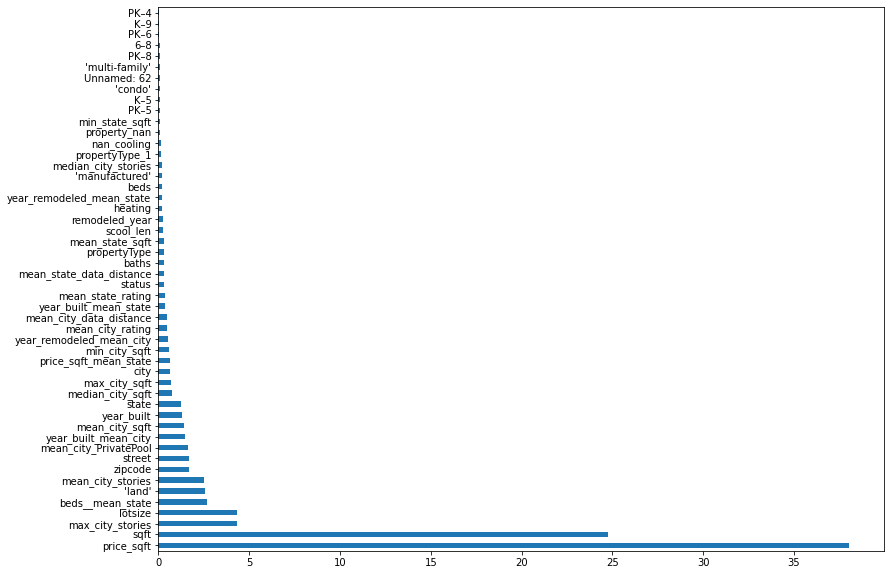

In [29]:
# Смотрим какие признаки были значимы для модели
plt.rcParams['figure.figsize'] = (13,10)
feat_importances = pd.Series(model_cat.feature_importances_, index=X_test.columns)
feat_importances.nlargest(50).plot(kind='barh')

# Random Forest


In [30]:
# Делим данные на трейн и вал.тест
Train, val, = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [31]:
data = Train
# Загружаем данные
#data = df.copy()

In [32]:
# Разделим признаки на числовые и категориальные
num_col = ['baths','sqft','beds','stories','PrivatePool','year_built',
           'remodeled_year','lotsize','price_sqft','mean_city_data_distance','year_built_mean_city',
           'year_remodeled_mean_city','mean_state_rating','mean_state_data_distance',
           'year_built_mean_state','year_remodeled_mean_state','beds__mean_state','median_city_sqft','mean_city_sqft','max_city_sqft','min_city_sqft',
           'min_state_sqft','mean_state_sqft','median_city_stories','mean_city_stories','min_state_stories',
           'mean_city_PrivatePool'
          ]


cat = ['status', 'propertyType', 'street','city', 'sqft', 
       'zipcode','state', 'heating','parking','propertyType_1','parking_',]


log_col = ['lotsize']

In [33]:
# При загрузке датасета проявляються столбцы с одинаковыми названиями применим функцию которая это исправит.
data = df_column_uniquify(data)

In [34]:
# Предобрабатываем данные трейна
y, data = PreProc(data, log_col,cat)

In [35]:
# Предобрабатываем данные вал теста
y_val, data_val = PreProc(val, log_col,cat)

In [36]:
# Заполяем оставшиеся пропуски средним
def fillna_mean(df):
    df = df.fillna(df.mean())
    return df

# Заполяем оставшиеся пропуски средним на трейне
data = fillna_mean(data)

# Заполяем оставшиеся пропуски средним на вал.тесте
data_val = fillna_mean(data_val)

In [37]:
# split данных
X_train, X_test, y_train, y_test = train_test_split(data, np.log(y), test_size=0.2, shuffle=True, random_state=42)

In [38]:
#estimator = RandomForestRegressor()
#param_grid = { 
#            "n_estimators"      : [10,50,100],
#            "max_features"      : ["sqrt", "log2"],
#            "min_samples_split" : [2,4,8],
#            "bootstrap": [True],
#            }
#grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, verbose=1)
#
#grid.fit(X_train, y_train)

In [39]:
#print(grid.best_score_) 
#print(grid.best_params_)

In [40]:
# Обучаем лес
forest = RandomForestRegressor(random_state=42, n_estimators=100,verbose=1, n_jobs=-1)

forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.0min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [48]:
# Результат метрики на трейне
forest_predict_train = forest.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.6s finished


In [49]:
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(forest_predict_train)))*100:0.2f}%")
print(f"TEST mae: {(mae(np.exp(y_test), np.exp(forest_predict_train))):0.0f}$")

TEST mape: 9.47%
TEST mae: 27667$


In [50]:
# Результат метрики на вал.тесте
forest_predict_val = forest.predict(data_val)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.9s finished


In [51]:
print(f"TEST mape: {(mape(y_val, np.exp(forest_predict_val)))*100:0.2f}%")
print(f"TEST mae: {(mae(y_val, np.exp(forest_predict_val))):0.0f}$")

TEST mape: 12.95%
TEST mae: 39836$


In [52]:
forest_predict_train = pd.Series(forest_predict_train)
forest_predict_train.to_csv('/content/gdrive/MyDrive/Diplom_project/forest_predict_train.csv')

In [53]:
forest_predict_val = pd.Series(forest_predict_val)
forest_predict_val.to_csv('/content/gdrive/MyDrive/Diplom_project/forest_predict_val.csv')

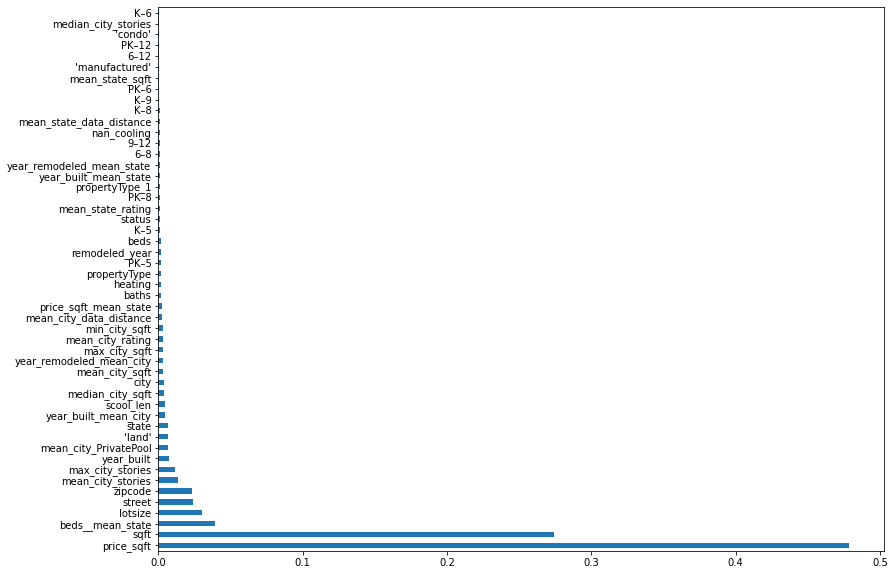

In [54]:
# Смотрим какие признаки были значимы для модели
plt.rcParams['figure.figsize'] = (13,10)
feat_importances = pd.Series(forest.feature_importances_, index=X_test.columns)
feat_importances.nlargest(50).plot(kind='barh')

# GradientBoostingRegressor

In [55]:
# Делим данные на трейн и вал.тест
Train, val, = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [56]:
data = Train
# Загружаем данные
#data = df.copy()

In [57]:
# Разделим признаки на числовые и категориальные
num_col = ['baths','sqft','beds','stories','PrivatePool','year_built',
           'remodeled_year','lotsize','price_sqft','mean_city_data_distance','year_built_mean_city',
           'year_remodeled_mean_city','mean_state_rating','mean_state_data_distance',
           'year_built_mean_state','year_remodeled_mean_state','beds__mean_state','median_city_sqft','mean_city_sqft','max_city_sqft','min_city_sqft',
           'min_state_sqft','mean_state_sqft','median_city_stories','mean_city_stories','min_state_stories',
           'mean_city_PrivatePool'
          ]


cat = ['status', 'propertyType', 'street','city', 'sqft', 
       'zipcode','state', 'heating','parking','propertyType_1','parking_',]


log_col = ['lotsize']

In [58]:
# При загрузке датасета проявляються столбцы с одинаковыми названиями применим функцию которая это исправит.
data = df_column_uniquify(data)

In [59]:
# Предобрабатываем данные трейна
y, data = PreProc(data, log_col,cat)

In [60]:
# Предобрабатываем данные вал теста
y_val, data_val = PreProc(val, log_col,cat)

In [61]:
# Заполяем оставшиеся пропуски средним на трейне
data = fillna_mean(data)

# Заполяем оставшиеся пропуски средним на вал.тесте
data_val = fillna_mean(data_val)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, np.log(y), test_size=0.2, shuffle=True, random_state=42)

In [ ]:
#estimator = GradientBoostingRegressor()
#param_grid = { 
#            "n_estimators"      : [10,100,500],
#            "max_features"      : ["sqrt", "log2"],
#            "min_samples_split" : [2,4,8],
#            "bootstrap": [True],
#            }
#grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, verbose=1)

#grid.fit(X_train, y_train)


In [63]:
grad = GradientBoostingRegressor(n_estimators=200,learning_rate=0.1,random_state=42, verbose = 1, max_depth = 10)
grad.fit(X_train, y_train)
grad_test_predict = grad.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1           0.6587           25.21m
         2           0.5574           25.97m
         3           0.4751           25.53m
         4           0.4081           25.30m
         5           0.3523           25.09m
         6           0.3069           24.94m
         7           0.2698           24.79m
         8           0.2393           24.65m
         9           0.2138           24.52m
        10           0.1928           24.37m
        20           0.1071           23.15m
        30           0.0881           21.85m
        40           0.0802           20.46m
        50           0.0758           18.83m
        60           0.0711           17.32m
        70           0.0678           15.80m
        80           0.0655           14.38m
        90           0.0631           13.04m
       100           0.0611           11.74m
       200           0.0436            0.00s


In [64]:
# Результат метрики на трейне
grad_test_predict_train = grad.predict(X_test)

In [65]:
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(grad_test_predict_train)))*100:0.2f}%")
print(f"TEST mae: {(mae(np.exp(y_test), np.exp(grad_test_predict_train))):0.0f}$")

TEST mape: 10.35%
TEST mae: 30422$


In [67]:
# Результат метрики на вал.тесте
grad_test_predict_val = grad.predict(data_val)

In [79]:
print(f"TEST mape: {(mape(y_val, np.exp(grad_test_predict_val)))*100:0.2f}%")
print(f"TEST mae: {(mae(y_val, np.exp(grad_test_predict_val))):0.0f}$")

TEST mape: 13.41%
TEST mae: 42936$


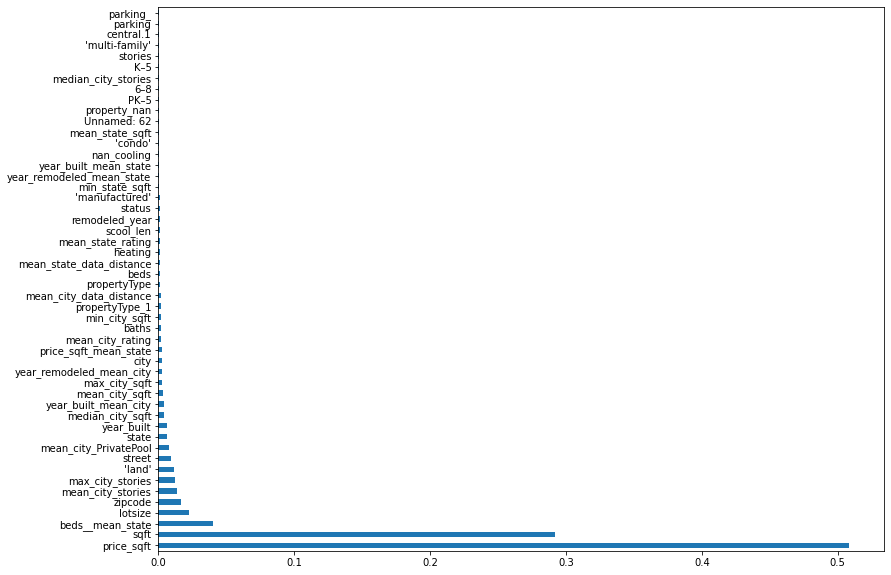

In [69]:
# Смотрим какие признаки были значимы для модели
plt.rcParams['figure.figsize'] = (13,10)
feat_importances = pd.Series(grad.feature_importances_, index=X_test.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [70]:
grad_test_predict_train = pd.Series(grad_test_predict_train)
grad_test_predict_train.to_csv('/content/gdrive/MyDrive/Diplom_project/grad_test_predict_train.csv')

In [71]:
grad_test_predict_val = pd.Series(grad_test_predict_val)
grad_test_predict_val.to_csv('/content/gdrive/MyDrive/Diplom_project/grad_test_predict_val.csv')

# StackingRegressor

In [ ]:
# По причине долгих вычислений на kaggle, пришлось ограничить число деревьев в каждом методе до 100.
estimators = [
              ('Cat', CatBoostRegressor(iterations=2000,
                                        learning_rate = 0.01,
                                        random_seed=42,
                                        silent=True,
                                        l2_leaf_reg=2,
                                        #task_type='GPU'
                                        )),
    
              ('Grad', GradientBoostingRegressor(min_samples_split=2,
                               learning_rate=0.1,
                               n_estimators=100,
                               random_state = 42,
                               max_depth = 10 )),
    
              ('forest', RandomForestRegressor(n_jobs=-1,max_features= 'auto' ,
                                               n_estimators=100,
                                               oob_score = True, random_state=42))
               
               ]

st_ensemble = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(),verbose = 1)

# оцениваем точность
st_ensemble.fit(X_train, np.log(y_train))




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 55.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 59.2min finished


StackingRegressor(estimators=[('Cat',
                               <catboost.core.CatBoostRegressor object at 0x7f3181da1ed0>),
                              ('Grad',
                               GradientBoostingRegressor(max_depth=10,
                                                         random_state=42)),
                              ('forest',
                               RandomForestRegressor(n_jobs=-1, oob_score=True,
                                                     random_state=42))],
                  final_estimator=LinearRegression(), verbose=1)

In [ ]:
# Результат метрики на трейне
stack_test_predict_train = np.exp(st_ensemble.predict(X_test))

In [123]:
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(stack_test_predict_train)))*100:0.2f}%")
print(f"TEST mae: {(mae(np.exp(y_test), np.exp(stack_test_predict_train))):0.0f}$")

TEST mape: 9.41%
TEST mae: 29446$


In [ ]:
# Результат метрики на вал.тесте
stack_test_predict_val = np.exp(st_ensemble.predict(data_val))

In [124]:
print(f"TEST mape: {(mape(y_val, np.exp(stack_test_predict_val)))*100:0.2f}%")
print(f"TEST mae: {(mae(y_val, np.exp(stack_test_predict_val))):0.0f}$")

TEST mape: 12.94%
TEST mae: 41954$


In [ ]:
stack_test_predict_train = pd.Series(stack_test_predict_train)
stack_test_predict_train.to_csv('/content/gdrive/MyDrive/Diplom_project/stack_test_predict_train.csv')

In [ ]:
stack_test_predict_val = pd.Series(stack_test_predict_val)
stack_test_predict_val.to_csv('/content/gdrive/MyDrive/Diplom_project/stack_test_predict_val.csv')

# Загрузки предсказаний

In [74]:
catboost_predict_train = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/catboost_predict_train.csv').drop(['Unnamed: 0'], axis = 1)
forest_predict_train = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/forest_predict_train.csv').drop(['Unnamed: 0'], axis = 1)
grad_test_predict_train = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/grad_test_predict_train.csv').drop(['Unnamed: 0'], axis = 1)
stack_test_predict_train = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/stack_test_predict_train.csv').drop(['Unnamed: 0'], axis = 1)

In [75]:
catboost_predict_val = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/catboost_predict_val.csv').drop(['Unnamed: 0'], axis = 1)
forest_predict_val = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/forest_predict_val.csv').drop(['Unnamed: 0'], axis = 1)
grad_test_predict_val = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/grad_test_predict_val.csv').drop(['Unnamed: 0'], axis = 1)
stack_test_predict_val = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/stack_test_predict_val.csv').drop(['Unnamed: 0'], axis = 1)

# Blending

## Blending c Gradboost

In [77]:
blend_predict_train = (np.exp(catboost_predict_train.values) + np.exp(forest_predict_train.values) + np.exp(grad_test_predict_train.values)) / 3
print(f"Train mape: {(mape(np.exp(y_test), blend_predict_train))*100:0.2f}%")
print(f"Train mae: {(mae(np.exp(y_test), blend_predict_train)):0.0f}$")
blend_predict_val = (np.exp(catboost_predict_val.values) + np.exp(forest_predict_val.values) + np.exp(grad_test_predict_val.values)) / 3
print(f"Val mape: {(mape(y_val, blend_predict_val))*100:0.2f}%")
print(f"Val mae: {(mae(y_val, blend_predict_val)):0.0f}$")

Train mape: 9.92%
Train mae: 29733$
Val mape: 11.79%
Val mae: 39180$


## Blending со стекингом

In [80]:
blend_predict_train = (np.exp(catboost_predict_train.values) + np.exp(forest_predict_train.values) + np.exp(stack_test_predict_train.values)) / 3
print(f"Train mape: {(mape(np.exp(y_test), blend_predict_train))*100:0.2f}%")
print(f"Train mae: {(mae(np.exp(y_test), blend_predict_train)):0.0f}$")
blend_predict_val = (np.exp(catboost_predict_val.values) + np.exp(forest_predict_val.values)+ np.exp(stack_test_predict_val.values)) / 3
print(f"Val mape: {(mape(y_val, blend_predict_val))*100:0.2f}%")
print(f"Val mae: {(mae(y_val, blend_predict_val)):0.0f}$")

Train mape: 9.63%
Train mae: 29184$
Val mape: 11.67%
Val mae: 38697$


# Результаты тестов

In [81]:
# Результаты метрик.
score_train = {'cat_train': [11.40,36524],
       'rand_forest_train':[9.47,27667],
       'grad_boost_train':[10.35,30422],
       'stacking_train':[9.41,29446],
       'blending_grad_train':[9.92,29733],
       'blending_stack_train':[9.63,29184]}


score_val = {
       'cat_val':[10.86,42094],
       'rand_forest_val':[12.95,39836],
       'grad_boost_val':[13.41,42936],
       'stacking_val':[12.94,41954],
       'blending_grad_val':[11.79,39180],
       'blending_stack_val':[11.67,38697]}


print('Score на train')
print(pd.DataFrame(score_train).T.sort_values(by = 0).rename(columns = {0 : 'MAPE', 1: 'MAE'}))
print('-----------------------------------')
print('Score на val')
print(pd.DataFrame(score_val).T.sort_values(by = 0).rename(columns = {0 : 'MAPE', 1: 'MAE'}))

Score на train
                       MAPE      MAE
stacking_train         9.41  29446.0
rand_forest_train      9.47  27667.0
blending_stack_train   9.63  29184.0
blending_grad_train    9.92  29733.0
grad_boost_train      10.35  30422.0
cat_train             11.40  36524.0
-----------------------------------
Score на val
                     MAPE      MAE
cat_val             10.86  42094.0
blending_stack_val  11.67  38697.0
blending_grad_val   11.79  39180.0
stacking_val        12.94  41954.0
rand_forest_val     12.95  39836.0
grad_boost_val      13.41  42936.0


# **Выводы:** 
1. Разделили данные на числовые и категориальные признаки.
2. Провели анализ числовых и категориальных признаков.
3. Очистили данные  от выбросов (там где это принесло результат).
4. Создали новые признаки и отсеяли плохие из них в процесе экспериментов.
5. Провели анализ распределения и кореляции признаков.  
6. Из категориальных признаков выделили dummy признаки.
7. Выбрали метрику МАРЕ так как с ней удобно сравнивать модели.
8. Было опробовано несколько моделей.
*   GradientBoostingRegressor трейн
*   RandomForestRegressor трейн
*   StackingRegressor.  трейн
*   CatBoostRegressor трейн
9. Применили Blending трейн
* Лучший результат показал на трейне показал StackingRegressor.
* Лучший результат показал на вал.тесте показал CatBoostRegressor.
* Разница значений на трейнах и вал.тестах около 3%, между блендингами 2%.
* Итоговая модель Catboost
10. Что не удалось: 

*   Не удалось применить DL из-за того, что датасет слишком разросся и не вле6зает в RAM как googlecolab так и Kaggle. Нужно подумвть,что с этим делать. Так как нейронная сеть работает иначе чем ансамбли блендинг с ее участием может показать хороший результат.  
*   Пока не получилось применить GridSearch для подбора гиперпараметров моделей из-за продолжительности процеса. 

11. Что еще можно зделать:
*   Возможно еще привлечь данные о населении городов, отдаленности от обласных центров(столиц штатов), рейтинг криминальностигородов(раенов), доступность центров развлечений(магазинов) и т.д.
12. Датасет был слишком загрязнен. И в процесе очистки почти стопроцентно были допущены ошибки. Так как garbage in, garbage out, это очевидно уменьшает score.Это можно решить более глубокой обработкой текста(в реальной жизни скорее всего плохой вариант). Или (представим, что мы владельцы ресурса где данные собирались) зделать процес записи данных в виде бланка с указаными возможными категориями. 